In [ ]:
pip install torchviz

In [ ]:
pip install torchmetrics torchview

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchmetrics import Accuracy
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader
from torchviz import make_dot
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import numpy as np
import logging

In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("../../training.log"),
        logging.StreamHandler()
    ],
    force=True
)

In [ ]:
dataset_path = "/content/drive/MyDrive"

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [ ]:
class DatasetManager:
    def __init__(self, batch_size=64, num_workers=2):
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomRotation(10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomGrayscale(p=0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        self.test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def load_cifar10(self, root):
        trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=self.train_transform)
        testset = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=self.test_transform)

        trainloader = DataLoader(trainset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        testloader = DataLoader(testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        return trainloader, testloader, classes

In [ ]:
class ModelTrainer:
    def __init__(self, model, device, criterion, optimizer, scheduler, num_classes=10):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.history = {
            "train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": [],
        }
        self.class_accuracy = {i: [] for i in range(num_classes)}
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(self.device)

    def train_epoch(self, dataloader):
        self.model.train()
        running_loss = 0
        self.accuracy.reset()

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            self.accuracy.update(outputs, labels)

        train_acc = self.accuracy.compute().item()
        return running_loss / len(dataloader), train_acc

    def evaluate_model(self, dataloader):
        self.model.eval()
        loss_total = 0
        class_acc_metric = MulticlassAccuracy(num_classes=len(self.class_accuracy), average=None).to(self.device)
        self.accuracy.reset()

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss_total += self.criterion(outputs, labels).item()

                preds = torch.argmax(outputs, dim=1)
                self.accuracy.update(outputs, labels)
                class_acc_metric.update(preds, labels)

        acc_per_class = class_acc_metric.compute().cpu().numpy()
        for i, acc in enumerate(acc_per_class):
            self.class_accuracy[i].append(acc)

        test_acc = self.accuracy.compute().item()
        return loss_total / len(dataloader), test_acc

    def train_model(self, trainloader, testloader, epochs=10, save_path="model.pth"):
        best_acc = 0.0
        best_epoch = 0

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(trainloader)
            test_loss, test_acc = self.evaluate_model(testloader)
            self.scheduler.step()

            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["test_loss"].append(test_loss)
            self.history["test_acc"].append(test_acc)

            if test_acc > best_acc:
                best_acc = test_acc
                best_epoch = epoch
                torch.save(self.model.state_dict(), save_path)

            logging.info(f"Эпоха {epoch + 1}/{epochs} "
                         f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
                         f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")

        logging.info(f"Лучшее значение точности: {100 * best_acc:.4f} достигнуто на {best_epoch + 1} эпохе")
        logging.info(f"Модель сохранена как '{save_path}'")
        return self.history, self.class_accuracy

In [ ]:
class Visualizer:
    @staticmethod
    def visualize_graph(model, device, input_size=(1, 3, 32, 32)):
        model.eval()
        inputt = torch.randn(input_size).to(device)
        output = model(inputt)

        dot = make_dot(output, params=dict(model.named_parameters()))
        dot.format = 'png'

        img_bytes = BytesIO(dot.pipe(format='png'))
        img = Image.open(img_bytes)

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    @staticmethod
    def plot_history(history, save_path="training_results.png"):
        epochs = range(1, len(history["train_loss"]) + 1)

        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, history["train_loss"], 'b--', label='Train Loss')
        plt.plot(epochs, history["test_loss"], 'r-', label='Test Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, history["train_acc"], 'b--', label='Train Accuracy')
        plt.plot(epochs, history["test_acc"], 'r-', label='Test Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(save_path)
        logging.info(f"The training schedule has been saved as '{save_path}'")

    @staticmethod
    def show_predictions(model, dataloader, classes, device, num_images=8, normalize=True):
        model.eval()
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        predicted = predicted.cpu().numpy()
        if normalize: images = (images / 2 + 0.5)

        fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 3))
        if num_images == 1: axes = [axes]

        for i in range(num_images):
            img = np.transpose(images[i], (1, 2, 0))
            axes[i].imshow(img)
            axes[i].axis('off')

            color = 'green' if predicted[i] == labels[i] else 'red'
            axes[i].spines['top'].set_color(color)
            axes[i].spines['top'].set_linewidth(3)

            axes[i].set_title(f"{classes[predicted[i]]}", color=color)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_class_accuracy(class_acc, classes, save_path="class_accuracy.png"):
        last_acc = [100 * class_acc[i][-1] for i in range(len(classes))]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(classes, last_acc, color='skyblue')

        plt.title("Model accuracy for each class")
        plt.ylabel("Accuracy (%)")
        plt.xticks(rotation=45)
        plt.ylim(0, 100)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        for bar, acc in zip(bars, last_acc):
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height + 1,
                f"{acc:.1f}%",
                ha='center', va='bottom', fontsize=10, fontweight='bold'
            )

        plt.tight_layout()
        plt.savefig(save_path)
        logging.info(f"The accuracy histogram by class is saved as '{save_path}'")
        plt.show()

In [ ]:
class ModelStudy:
    def __init__(self, data_root):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.data_root = data_root

    def conduct_study(self):
        logging.info(f"New network launch")
        logging.info(f"Device: {self.device}")

        data = DatasetManager()
        trainloader, testloader, classes = data.load_cifar10(self.data_root)

        model = CNN(len(classes)).to(self.device)
        criterion = nn.CrossEntropyLoss()

        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4, betas=(0.9, 0.999))
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120, eta_min=1e-6)

        logging.info(f"Model: {model}")
        logging.info(f"Error function: {criterion}")
        logging.info(f"Optimizer: {optimizer}")
        logging.info(f"Scheduler: {scheduler}")

        trainer = ModelTrainer(model, self.device, criterion, optimizer, scheduler)
        history, class_acc = trainer.train_model(trainloader, testloader, epochs=100, save_path="cifar10_cnn.pth")

        Visualizer.visualize_graph(model, self.device)
        Visualizer.plot_history(history)
        Visualizer.plot_class_accuracy(class_acc, classes)
        Visualizer.show_predictions(model, testloader, classes, self.device)
        logging.info(f"")

2025-11-14 14:52:18,832 - INFO - New network launch
2025-11-14 14:52:18,834 - INFO - Device: cuda
2025-11-14 14:52:33,483 - INFO - Model: CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.3, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (

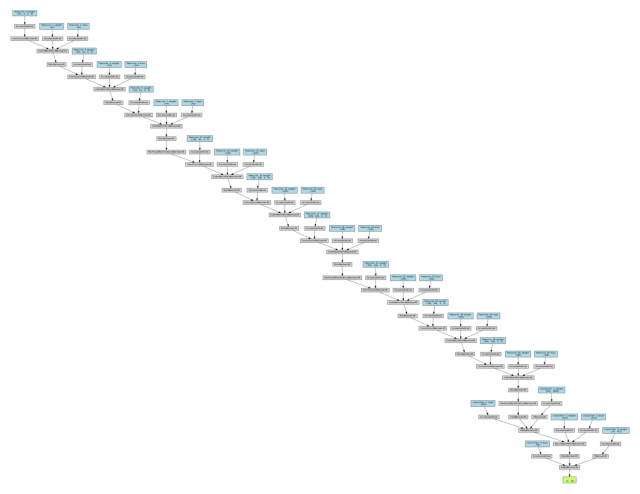

2025-11-14 16:31:29,945 - INFO - The training schedule has been saved as 'training_results.png'
2025-11-14 16:31:30,131 - INFO - The accuracy histogram by class is saved as 'class_accuracy.png'


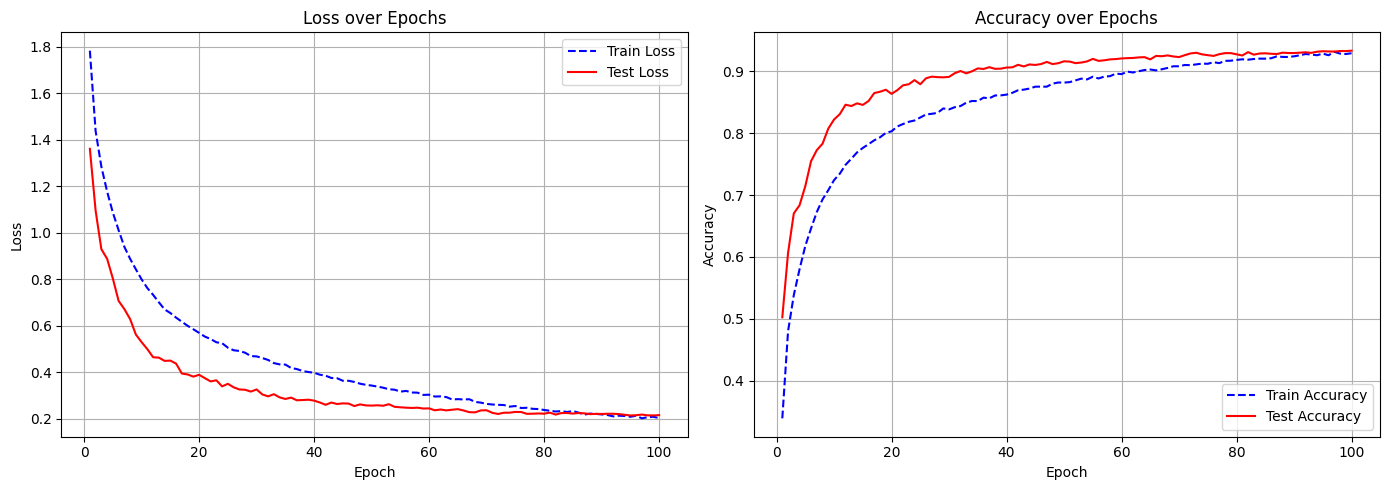

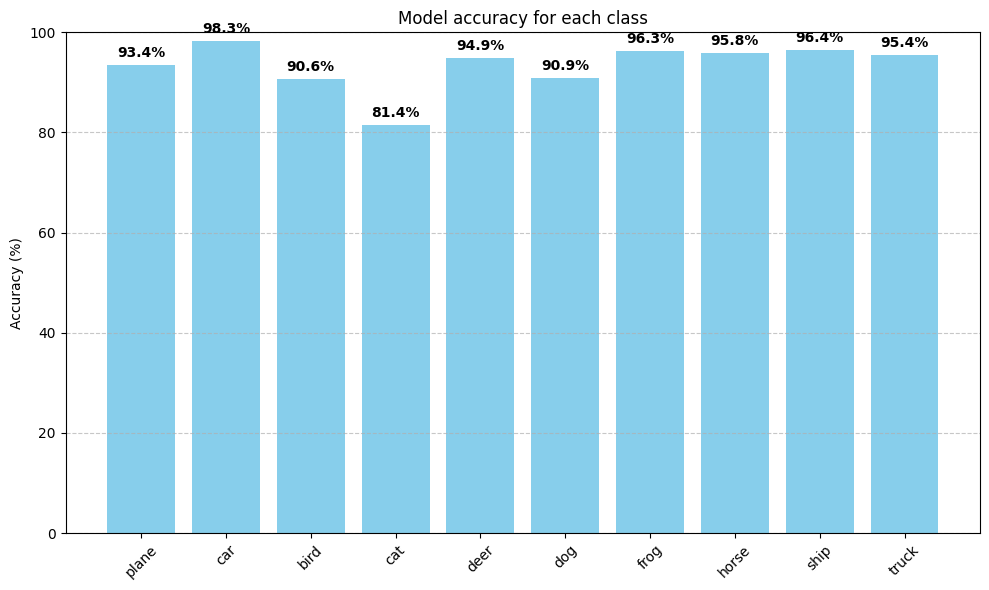

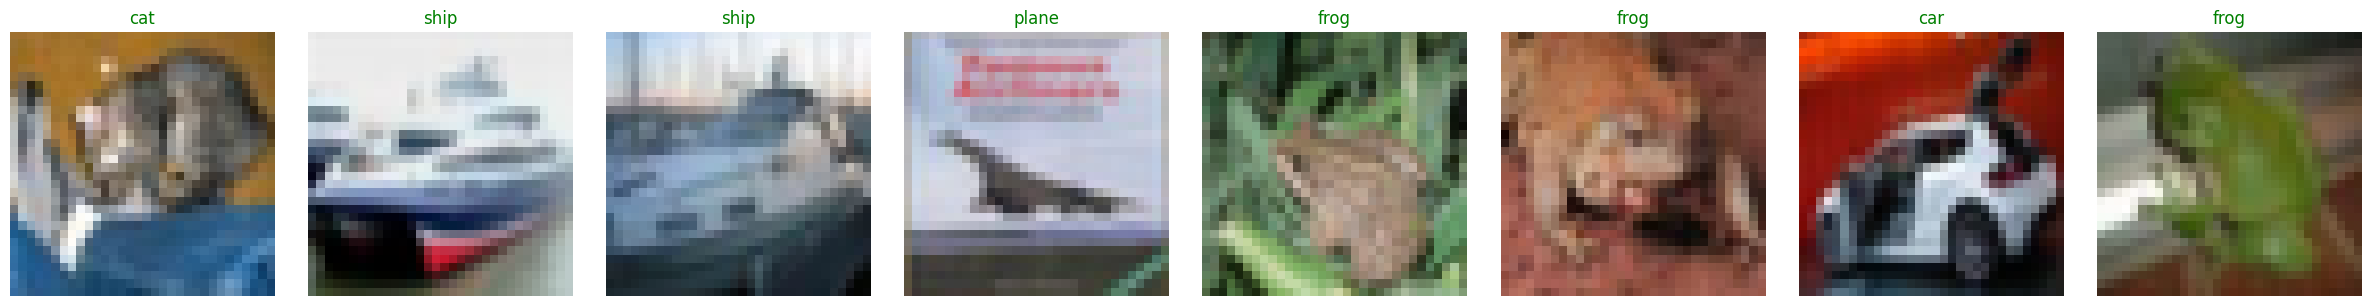

2025-11-14 16:31:31,156 - INFO - 


In [ ]:
if __name__ == "__main__":
    ModelStudy(dataset_path).conduct_study()